# Pre Generation Filtering

Inputs:

1. `model`: Trained rf-time-gan model
2. `given_metadata`: Conditions with metadata values that sessions should have (e.g., all sessions should have `gender = "M"`)

Output:

1. `dataset`: Synthetic dataset with sessions whose metadata fields match the values in `given_metadata`


### Install and Import Rockfish SDK


In [4]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [5]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
import pandas as pd

### Connect to the Rockfish Platform


In [7]:
api_key = ""  # API key for environment
api_url = ""  # URL for environment
conn = rf.Connection.remote(api_url, api_key)

### Train Rf-Time-GAN on the Finance Dataset


In [8]:
!wget --no-clobber https://docs.rockfish.ai/tutorials/finance.csv
dataset = rf.Dataset.from_csv("finance", "finance.csv")

--2024-12-12 18:52:04--  https://docs.rockfish.ai/tutorials/finance.csv


I0000 00:00:1734058323.910920 8424888 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


Resolving docs.rockfish.ai (docs.rockfish.ai)... 2600:9000:249b:5800:3:1cb5:3480:93a1, 2600:9000:249b:1800:3:1cb5:3480:93a1, 2600:9000:249b:d200:3:1cb5:3480:93a1, ...
Connecting to docs.rockfish.ai (docs.rockfish.ai)|2600:9000:249b:5800:3:1cb5:3480:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3444556 (3.3M) [text/csv]
Saving to: ‘finance.csv’

finance.csv         100%[===================>]   3.28M  7.22MB/s    in 0.5s    

2024-12-12 18:52:06 (7.22 MB/s) - ‘finance.csv’ saved [3444556/3444556]



In [9]:
def get_config(
    epochs=1, sample_len=2, sessions=100, batch_size=512, given_metadata=None
):
    timestamp = "timestamp"
    session = "customer"
    metadata_cols = ["age", "gender"]
    con_measurement_cols = ["amount"]
    cat_measurement_cols = ["merchant", "category", "fraud"]
    config = ra.TrainTimeGAN.Config(
        encoder=ra.TrainTimeGAN.DatasetConfig(
            timestamp=ra.TrainTimeGAN.TimestampConfig(field=timestamp),
            metadata=[
                ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                for col in metadata_cols
            ]
            + [ra.TrainTimeGAN.FieldConfig(field=session, type="session")],
            measurements=[
                ra.TrainTimeGAN.FieldConfig(field=col, type="continuous")
                for col in con_measurement_cols
            ]
            + [
                ra.TrainTimeGAN.FieldConfig(field=col, type="categorical")
                for col in cat_measurement_cols
            ],
        ),
        doppelganger=ra.TrainTimeGAN.DGConfig(
            epoch=epochs,
            epoch_checkpoint_freq=epochs,
            sample_len=sample_len,
            sessions=sessions,
            batch_size=batch_size,
            given_metadata=given_metadata,
        ),
    )
    return config

In [10]:
train_config = get_config()  # pass appropriate args for setting hyperparams
train = ra.TrainTimeGAN(train_config)

builder = rf.WorkflowBuilder()
builder.add_path(dataset, train)
workflow = await builder.start(conn)
print(f"Train Workflow: {workflow.id()}")

Train Workflow: 4u4qHv26xGrGuKlojkFS0t


In [11]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2024-12-13T02:52:16Z dataset-load: INFO Loading dataset '6d7NNcTXXVgpUKxdf6ctIn' with 50000 rows
2024-12-13T02:52:07Z train-time-gan: DEBUG CUDA available
2024-12-13T02:52:07Z train-time-gan: DEBUG Training on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2024-12-13T02:52:14Z train-time-gan: INFO Starting DG training job
2024-12-13T02:52:15Z train-time-gan: DEBUG Epoch 1, g_loss_d: -0.7232, g_loss: -0.6521, d_loss_fake:  0.7125, d_loss_real: -9.1946, d_loss_gp:  0.1579, d_loss: -6.9028, g_loss_attr_d:  0.0711, attr_d_loss_fake: -0.0535, attr_d_loss_real: -1.0995, attr_d_loss_gp:  0.0189, attr_d_loss: -0.9639
2024-12-13T02:52:15Z train-time-gan: INFO Epoch 1 completed.
2024-12-13T02:52:15Z train-time-gan: DEBUG Checkpoint on Epoch 1 has been saved to epoch-1.pt
2024-12-13T02:52:17Z train-time-gan: INFO Training completed. Uploaded model 4369df7e-b8fd-11ef-9e7e-665e8c8b87d7


### Fetch the Trained Model


In [12]:
model = await workflow.models().last()

### Precondition While Generating


#### Example 1: One Condition

**User Intent**

Generate the following synthetic dataset: 25 sessions with metadata (age = 4, gender = M).


##### Specify these conditions in the generate config


In [13]:
# input: given_metadata = [(age = 4, gender = M)]
# expected output: 25 sessions with metadata = (age = 4, gender = M)
given_metadata1 = {"age": ["4"], "gender": ["M"]}
generate1_config = get_config(sessions=25, given_metadata=given_metadata1)
generate1 = ra.GenerateTimeGAN(generate1_config)

##### Run the generate workflow


In [14]:
save = ra.DatasetSave(name="synthetic")
builder = rf.WorkflowBuilder()
builder.add_path(model, generate1, save)
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 3tq71rwNYvIZHVHrNadDwV


In [15]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2024-12-13T02:52:18Z generate-time-gan: DEBUG CUDA available
2024-12-13T02:52:18Z generate-time-gan: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2024-12-13T02:52:18Z generate-time-gan: INFO Downloading model with model_id='4369df7e-b8fd-11ef-9e7e-665e8c8b87d7'...
2024-12-13T02:52:19Z generate-time-gan: INFO Generating 25 sessions...
2024-12-13T02:52:24Z generate-time-gan: DEBUG Generating data from model trained with 1 epochs
2024-12-13T02:52:24Z generate-time-gan: DEBUG DG generating 1 batch
2024-12-13T02:52:33Z dataset-save: INFO using field 'session_key' to concatenate tables
2024-12-13T02:52:34Z dataset-save: INFO Saved dataset '4jIS1RWdAkyhRa8DtMhTTr' with 248 rows


In [16]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)

In [17]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-10 04:54:14.468,5747.444177,4,M,M1416436880,wellnessandbeauty,0,0.0
1,2023-01-10 04:54:14.468,2152.094536,4,M,M1294758098,travel,1,1.0
2,2023-01-10 04:54:14.468,1442.788024,4,M,M1294758098,food,0,2.0
3,2023-01-10 04:54:14.468,6630.239739,4,M,M692898500,contents,1,3.0
4,2023-01-12 01:25:58.345,6629.085255,4,M,M677738360,transportation,1,3.0
...,...,...,...,...,...,...,...,...
243,2023-09-23 18:21:16.122,4072.233805,4,M,M151143676,fashion,1,22.0
244,2023-10-03 15:18:50.500,4081.905164,4,M,M855959430,transportation,0,22.0
245,2023-10-12 12:14:52.007,4094.730313,4,M,M151143676,leisure,1,22.0
246,2023-01-10 04:54:14.468,5892.488863,4,M,M349281107,food,0,23.0


##### Validate metadata fields are constrained to given_metadata:


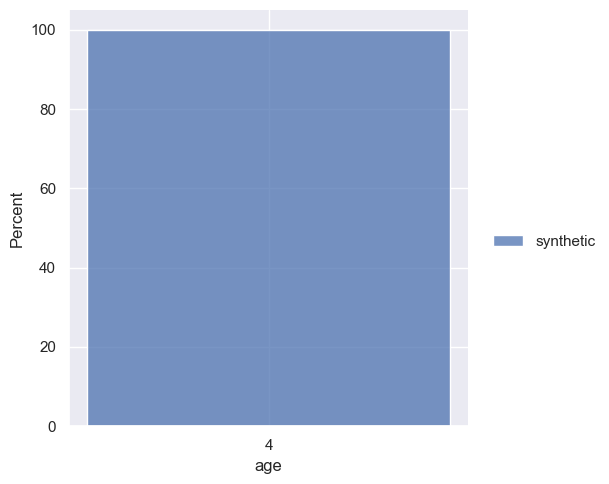

In [18]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

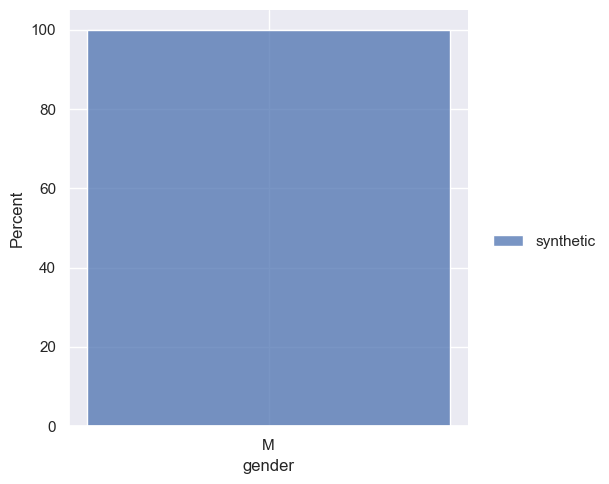

In [19]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")

#### Example 2: Multiple Conditions, Controlling Number of Sessions

**User Intent**

Generate the following synthetic dataset (using the same model):

1. 25 sessions with metadata (age = 4, gender = M)
2. 50 sessions with metadata either (age = 2, gender = F) or (age = 5, gender = M)


##### Specify these conditions in the generate config


In [20]:
# given_metadata = [(age = 2, gender = F), (age = 5, gender = M)]
# expected output: 50 sessions with metadata that can be either
# (age = 2, gender = F) or (age = 5, gender = M).
given_metadata2 = {"age": ["2", "5"], "gender": ["F", "M"]}
generate2_config = get_config(sessions=50, given_metadata=given_metadata2)
generate2 = ra.GenerateTimeGAN(generate2_config)

##### Run the generate workflow


In [21]:
save = ra.DatasetSave(
    name="synthetic", concat_tables=True, concat_session_key="session_key"
)

# this shows how you can add two different generate actions to the same workflow
builder = rf.WorkflowBuilder()
builder.add(model)
builder.add(
    generate1, parents=[model]
)  # re-using generate action from example 1
builder.add(
    generate2, parents=[model]
)  # using generate action from example 2
builder.add(save, parents=[generate1, generate2])
workflow = await builder.start(conn)
print(f"Generate Workflow: {workflow.id()}")

Generate Workflow: 7lYH3NshawBUfRLjAFOoTW


In [22]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2024-12-13T02:52:26Z generate-time-gan1: DEBUG CUDA available
2024-12-13T02:52:26Z generate-time-gan1: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2024-12-13T02:52:26Z generate-time-gan1: INFO Downloading model with model_id='4369df7e-b8fd-11ef-9e7e-665e8c8b87d7'...
2024-12-13T02:52:27Z generate-time-gan1: INFO Generating 50 sessions...
2024-12-13T02:52:29Z generate-time-gan1: DEBUG Generating data from model trained with 1 epochs
2024-12-13T02:52:30Z generate-time-gan1: DEBUG DG generating 1 batch
2024-12-13T02:52:30Z dataset-save: INFO using field 'session_key' to concatenate tables
2024-12-13T02:52:30Z dataset-save: INFO Saved dataset '7CY1MLhVzd1Xg4q1QQl6Hk' with 383 rows
2024-12-13T02:54:06Z generate-time-gan: DEBUG CUDA available
2024-12-13T02:54:06Z generate-time-gan: DEBUG Running on cuda:NVIDIA A100 80GB PCIe with cuda version 11.8
2024-12-13T02:54:06Z generate-time-gan: INFO Downloading model with model_id='4369df7e-b8fd-11ef-9e7e-665e8c8b87d7'...
2024-

In [23]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)

In [24]:
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-10 04:54:14.468,6479.311433,4,M,M2011752106,travel,1,50.0
1,2023-01-10 04:54:14.468,585.462897,4,M,M677738360,food,0,51.0
2,2023-01-10 04:54:14.468,5362.554136,4,M,M2122776122,health,0,52.0
3,2023-01-10 04:54:14.468,5473.604424,4,M,M17379832,food,1,53.0
4,2023-01-10 04:54:14.468,698.607738,4,M,M2011752106,health,0,54.0
...,...,...,...,...,...,...,...,...
553,2023-04-10 05:28:37.318,3919.198542,2,F,M151143676,fashion,1,46.0
554,2023-01-15 23:31:16.931,3867.022113,5,M,M349281107,contents,0,47.0
555,2023-01-17 19:52:59.090,4735.568691,2,F,M677738360,fashion,0,48.0
556,2023-01-15 23:31:16.931,6665.465264,5,M,M855959430,travel,0,49.0


##### Validate metadata fields are constrained to given_metadata:


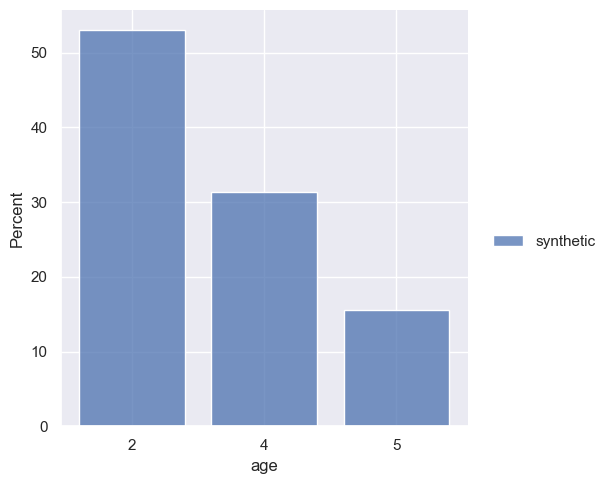

In [25]:
# plot age
rl.vis.plot_bar(datasets=[syn], field="age")

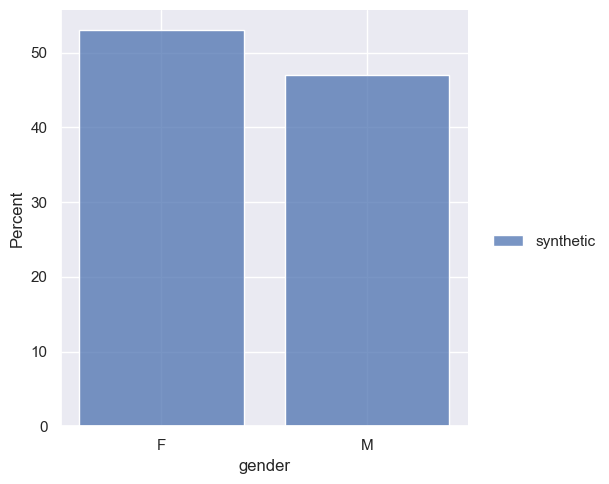

In [26]:
# plot gender
rl.vis.plot_bar(datasets=[syn], field="gender")